# 1. 基于 InceptionV3 的架构模型直接对人脸的进行识别

In [1]:
import matplotlib.pyplot as plt
from keras.preprocessing import image
import numpy as np


def plot_bar(predictions):
    types = [pred[1] for pred in predictions]
    probs = [pred[2] for pred in predictions]
    
    plt.barh(np.arange(len(probs)), probs)
    _ = plt.yticks(np.arange(3), types)
    plt.show()
    

def load_img(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    return x

Using TensorFlow backend.


Predicted: [(u'n04584207', u'wig', 0.9844466), (u'n03188531', u'diaper', 0.00455575), (u'n02817516', u'bearskin', 0.0010149482)]


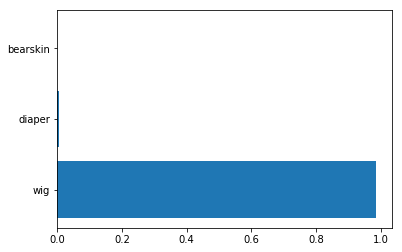

In [2]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions

def predicts_numbers():
    model = InceptionV3(weights='imagenet')

    img_path = "victor_0001.jpg"
    x = load_img(img_path)
    x = preprocess_input(x)
    preds = model.predict(x)

    predictions = decode_predictions(preds, top=3)[0]
    print('Predicted: {}'.format(predictions))
    plot_bar(predictions)
  
predicts_numbers()

# 2. 基于 InceptionV3 的架构的迁移学习，对30个人的所属姓名类别进行识别

In [3]:
from glob import glob

faces_names = [item[4:] for item in sorted(glob("lfw/train/*/*"))]
print("faces_names.len = {}".format(len(faces_names)))

faces_names.len = 70


Found 70 images belonging to 31 classes.
Found 31 images belonging to 31 classes.


/Users/victor/virtualenvlist/mydlp2/lib/python2.7/site-packages/ipykernel_launcher.py:34: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


First fitting the generator.
Epoch 1/2
70/70 [==============================] - 327s 5s/step - loss: 2.8443 - acc: 0.4269 - val_loss: 5.1146 - val_acc: 0.1290

Epoch 00001: val_loss improved from inf to 5.11463, saving model to inceptin_v3.faces.weights.best.h5
Epoch 2/2
70/70 [==============================] - 309s 4s/step - loss: 0.8485 - acc: 0.7593 - val_loss: 6.6712 - val_acc: 0.1935

Epoch 00002: val_loss did not improve from 5.11463
Second fitting the generator.
Epoch 1/2
70/70 [==============================] - 483s 7s/step - loss: 0.1994 - acc: 0.9647 - val_loss: 1.1904 - val_acc: 0.6129

Epoch 00001: val_loss improved from 5.11463 to 1.19044, saving model to inceptin_v3.faces.weights.best.h5
Epoch 2/2
70/70 [==============================] - 729s 10s/step - loss: 0.1164 - acc: 0.9827 - val_loss: 1.0214 - val_acc: 0.7419

Epoch 00002: val_loss improved from 1.19044 to 1.02140, saving model to inceptin_v3.faces.weights.best.h5
Saved model weights and architecture to disk


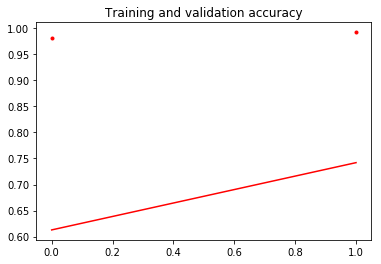

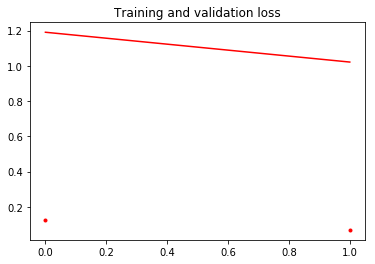

In [4]:
# 参考：
# 迁移学习：https://keras.io/applications/
# fit_generator: https://keras.io/preprocessing/image/
# callback: https://keras.io/callbacks/

num_classes = 31
img_width = 250
img_height = 250
img_channels = 3

from keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint  

import matplotlib.pyplot as plt
%matplotlib inline


def add_new_last_layers(base_model, num_classes):
    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)

    # and a logistic layer -- let's say we have num_classes classes
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(input=base_model.input, output=predictions)
    return model


def freeze_previous_layers(model, base_model):
    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


def fine_tune_model(model):
    # we chose to train the top 2 inception blocks, i.e. we will freeze
    # the first 249 layers and unfreeze the rest:
    for layer in model.layers[:172]:
        layer.trainable = False
    for layer in model.layers[172:]:
        layer.trainable = True

    model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
  
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r.')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')

    plt.figure()
    plt.plot(epochs, loss, 'r.')
    plt.plot(epochs, val_loss, 'r-')
    plt.title('Training and validation loss')
    plt.show()

checkpointer = ModelCheckpoint(filepath='inceptin_v3.faces.weights.best.h5', verbose=1, save_best_only=True)

def train(num_classes, batch_size, epochs):
  
    # data prep
    train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True
    )
    valid_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True
    )

    # data augmentation
    train_generator = train_datagen.flow_from_directory(
        'lfw/train',
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical')
    
    validation_generator = valid_datagen.flow_from_directory(
        'lfw/valid',
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical')

    # setup model
    # create the base pre-trained model
    base_model = InceptionV3(weights='imagenet', include_top=False) # include_top=False denotes that excludes final FC layer 
    model = add_new_last_layers(base_model, num_classes)

    # transfer learning
    freeze_previous_layers(model, base_model)

    print("First fitting the generator.")
    # train the model on the new data for a few epochs
    history_tl = model.fit_generator(train_generator, 
                      steps_per_epoch=len(faces_names), 
                      epochs=epochs,
                      verbose=1,              
                      validation_data=validation_generator,
                      callbacks=[checkpointer])

    # fine tune
    fine_tune_model(model)

    print("Second fitting the generator.")
    # we train our model again (this time fine-tuning the top 2 inception blocks
    # alongside the top Dense layers
    history_ft = model.fit_generator(train_generator, 
                      steps_per_epoch=len(faces_names), 
                      epochs=epochs,
                      verbose=1,              
                      validation_data=validation_generator,
                      callbacks=[checkpointer])


    # https://machinelearningmastery.com/save-load-keras-deep-learning-models/
    # serialize model to YAML
    model_yaml = model.to_yaml()
    with open("inceptin_v3_faces_weights_best.yaml", "w") as yaml_file:
        yaml_file.write(model_yaml)
    # serialize weights to HDF5 
    model.save_weights("inceptin_v3_faces_weights_best1.h5")
    print("Saved model weights and architecture to disk")

    plot_training(history_ft)


batch_size = 32
epochs = 2
train(num_classes, batch_size, epochs)


# 通过.yaml文件和.hdf5文件来加载InceptionV3的迁移学习模型

> yaml文件和json文件都可以保存模型的架构

> HDF5文件用来保存模型的权重

预测步骤：
- 1.加载模型架构
- 2.加载模型权重
- 3.预测

In [5]:
# 验证

# https://machinelearningmastery.com/save-load-keras-deep-learning-models/

from keras.applications.inception_v3 import preprocess_input
from keras.models import model_from_yaml
import matplotlib.pyplot as plt
from keras.preprocessing import image
import numpy as np

# load YAML and create model
with open('inceptin_v3_faces_weights_best.yaml', 'r') as yaml_file:
    loaded_model_yaml = yaml_file.read()
loaded_model = model_from_yaml(loaded_model_yaml)

# load weights into new model
loaded_model.load_weights("inceptin_v3_faces_weights_best1.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# score = loaded_model.evaluate(X_train, y_train, verbose=0)
# print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))


Loaded model from disk


# 可视化出类别概率直方图

The Max Probability : 0.864566802979 belongs to Victor_Zhang.


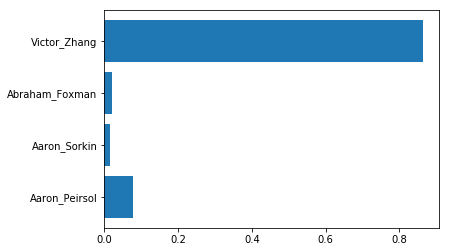

In [8]:

def load_face_img(trained_model):
    img_path = 'victor_test.jpg' 
    x = load_img(img_path)
    x = preprocess_input(x)
    predictions = trained_model.predict(x)

    faces_names = [item[10:] for item in sorted(glob("lfw/train/*"))]
    #predictions = decode_predictions(predictions, top=10)
    #print('Predicted: {}'.format(predictions))

    # 预测的概率数组
    prediction_list = predictions[0]
    
    # 取出最大概率值的索引
    max_index = np.argmax(prediction_list)
    print("The Max Probability : {} belongs to {}.".format(prediction_list[max_index], faces_names[max_index]))
    
    # 可视化打印前几个大于0.01的概率的值
    probs = []
    names = []
    i = 0
    for v in prediction_list:
        if v > 0.01:
            probs.append(v)
            names.append(faces_names[i])
        i+=1

    plt.barh(np.arange(len(probs)), probs)
    _ = plt.yticks(np.arange(len(probs)), names)
    plt.show()

load_face_img(loaded_model)